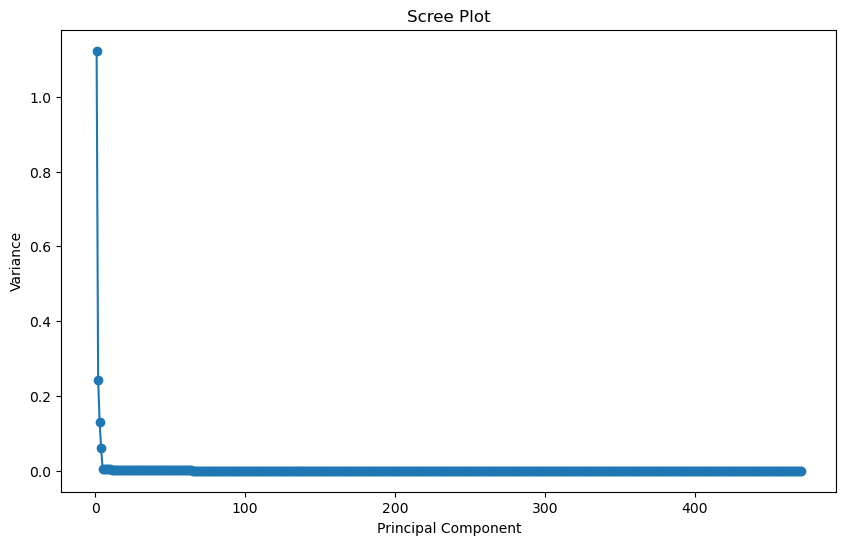

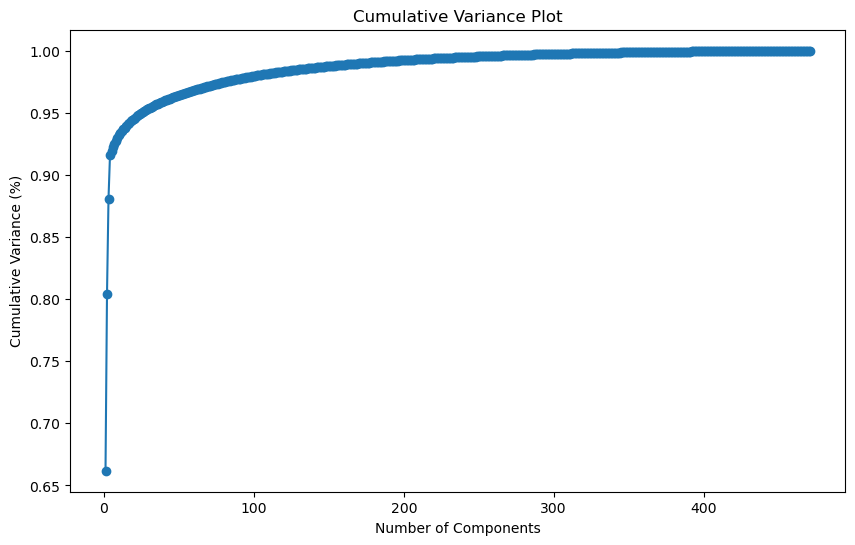

Number of components to capture at least 80% variance: 2


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the data
price_data = pd.read_csv("SP500_close_price_no_missing.csv", index_col=0)
ticker_data = pd.read_csv("SP500_ticker.csv", index_col=0)

# Derive log returns
log_returns = np.log(price_data / price_data.shift(1))

# Drop the first row with NaN values
log_returns = log_returns.dropna()

# Fit PCA model
pca = PCA()
pca.fit(log_returns)

# Plot scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.show()

# Create cumulative variance plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Variance Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.show()

# Find the number of components needed to capture 80% of the variance
cumulative_variance_80 = np.where(cumulative_variance >= 0.8)[0][0] + 1
print(f"Number of components to capture at least 80% variance: {cumulative_variance_80}")

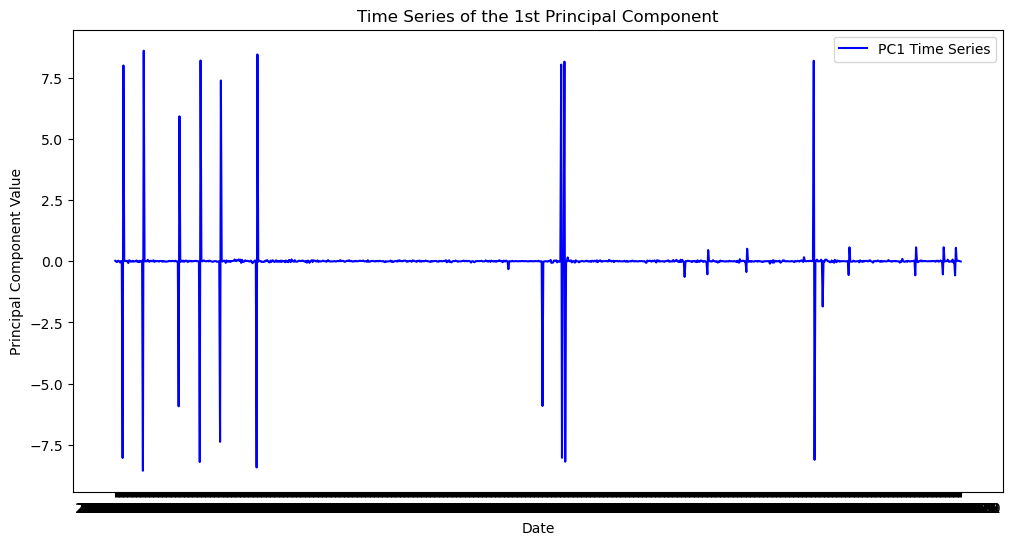

Date with the lowest value for the 1st principal component: 2011-02-21


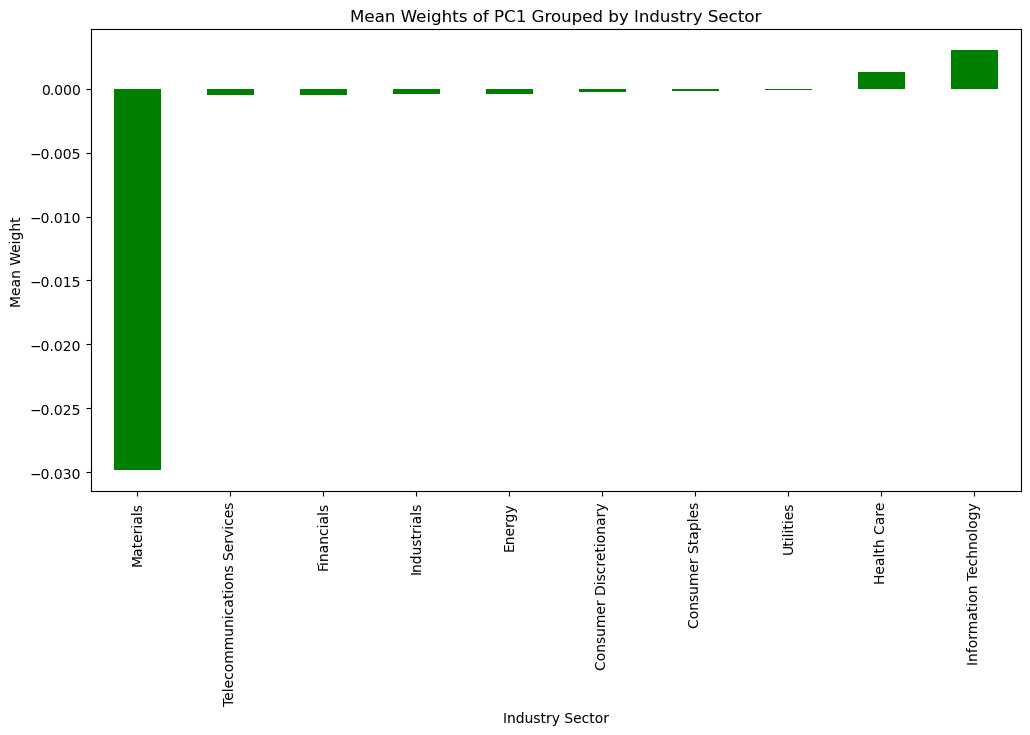

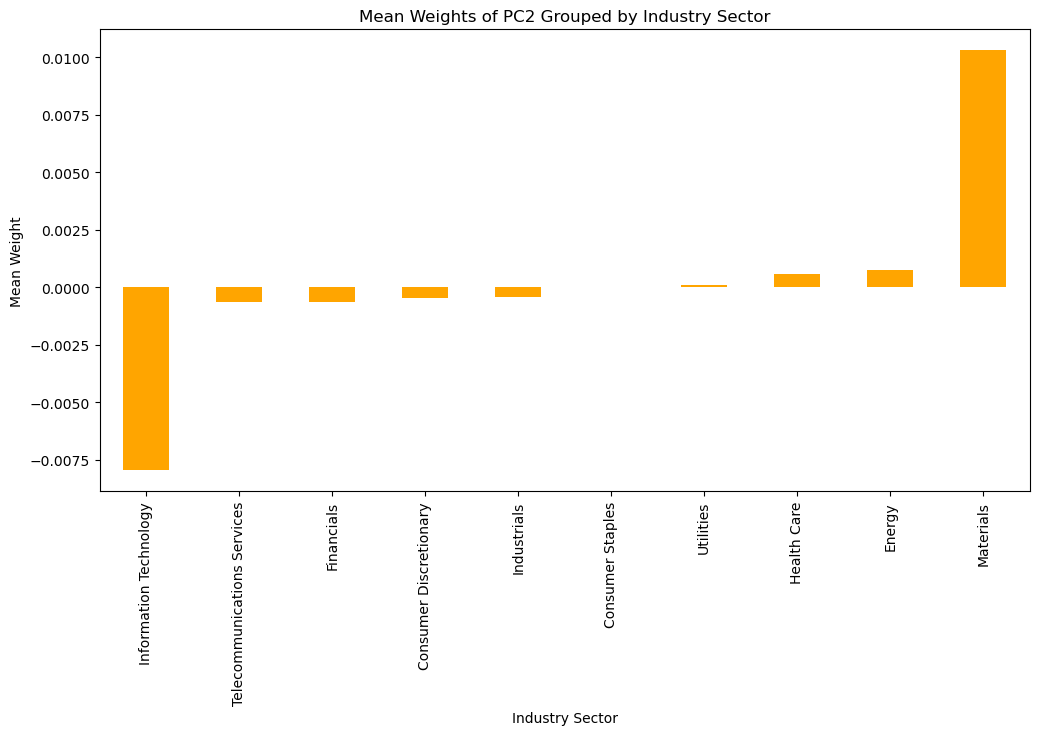

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the data
price_data = pd.read_csv("SP500_close_price_no_missing.csv", index_col=0)
ticker_data = pd.read_csv("SP500_ticker.csv", index_col=0, encoding='utf-8')

# Derive log returns
log_returns = np.log(price_data / price_data.shift(1))
log_returns = log_returns.dropna()

# Fit PCA model
pca = PCA()
pca.fit(log_returns)

# Compute and plot the time series of the 1st principal component
pc1_time_series = np.dot(log_returns, pca.components_[0, :])
plt.figure(figsize=(12, 6))
plt.plot(log_returns.index, pc1_time_series, label='PC1 Time Series', color='blue')
plt.title('Time Series of the 1st Principal Component')
plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.legend()
plt.show()

# Identify the date with the lowest value for the 1st principal component
min_pc1_date = log_returns.index[np.argmin(pc1_time_series)]
print(f"Date with the lowest value for the 1st principal component: {min_pc1_date}")

# Extract weights for 1st and 2nd principal components
pc1_weights = pca.components_[0, :]
pc2_weights = pca.components_[1, :]

# Merge weights with ticker data to get industry sector information
weights_df = pd.DataFrame({'Ticker': log_returns.columns, 'PC1_Weight': pc1_weights, 'PC2_Weight': pc2_weights})
weights_df = pd.merge(weights_df, ticker_data[['sector']], left_on='Ticker', right_index=True, how='left')

# Create a plot to show weights of the 1st principal component grouped by industry sector
plt.figure(figsize=(12, 6))
weights_df.groupby('sector')['PC1_Weight'].mean().sort_values().plot(kind='bar', color='green')
plt.title('Mean Weights of PC1 Grouped by Industry Sector')
plt.xlabel('Industry Sector')
plt.ylabel('Mean Weight')
plt.show()

# Create a similar plot for the 2nd principal component
plt.figure(figsize=(12, 6))
weights_df.groupby('sector')['PC2_Weight'].mean().sort_values().plot(kind='bar', color='orange')
plt.title('Mean Weights of PC2 Grouped by Industry Sector')
plt.xlabel('Industry Sector')
plt.ylabel('Mean Weight')
plt.show()



In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Load the data
data = pd.read_csv("BMI.csv")

# Separate features (X) and target variable (y)
X = data.drop('fatpctg', axis=1)
y = data['fatpctg']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# a) Wrapper method: Backward and Forward Stepwise Regression
def backward_stepwise_regression(X, y):
    cols = list(X.columns)
    pmax = 1
    while len(cols) > 0:
        p = []
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y, X_1).fit()
        p = pd.Series(model.pvalues.values[1:], index=cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if pmax > 0.05:
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features = cols
    return selected_features

def forward_stepwise_regression(X, y):
    cols = list(X.columns)
    selected_features = []
    pmax = 1
    while len(cols) > 0:
        p = []
        remaining_features = list(set(cols) - set(selected_features))
        for feature in remaining_features:
            X_1 = X[selected_features + [feature]]
            X_1 = sm.add_constant(X_1)
            model = sm.OLS(y, X_1).fit()
            p.append((feature, model.pvalues[-1]))
        p = sorted(p, key=lambda x: x[1])
        pmax = p[0][1]
        if pmax < 0.05:
            selected_features.append(p[0][0])
        else:
            break
    return selected_features

print("Wrapper method - Backward Stepwise Regression:")
print(backward_stepwise_regression(X_train, y_train))
print("\nWrapper method - Forward Stepwise Regression:")
print(forward_stepwise_regression(X_train, y_train))

# b) Filter method: Correlation Statistics
correlation_ranking = abs(data.corr()['fatpctg']).sort_values(ascending=False).drop('fatpctg')
print("\nFilter method - Correlation Statistics:")
print(correlation_ranking)

# c) Embedded method:
# (1) Lasso Regression
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
lasso_ranking = abs(lasso_coefficients).sort_values(ascending=False)
print("\nEmbedded method - Lasso Regression:")
print(lasso_ranking)

# (2) Random Forest (Feature Importance Ranking)
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)
random_forest_ranking = pd.Series(random_forest_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nEmbedded method - Random Forest (Feature Importance):")
print(random_forest_ranking)

Wrapper method - Backward Stepwise Regression:
['Weight', 'Abdomen', 'Wrist']

Wrapper method - Forward Stepwise Regression:
['Abdomen', 'Wrist', 'Weight']

Filter method - Correlation Statistics:
Abdomen    0.813432
Chest      0.702620
Hip        0.625201
Weight     0.612925
Thigh      0.559608
Knee       0.508665
Biceps     0.493271
Neck       0.490592
Forearm    0.361387
Wrist      0.346575
Age        0.291458
Ankle      0.265970
Height     0.133211
Name: fatpctg, dtype: float64

Embedded method - Lasso Regression:
Wrist      2.109029
Abdomen    0.980187
Neck       0.422322
Biceps     0.314264
Forearm    0.232864
Thigh      0.160673
Ankle      0.134259
Hip        0.127771
Chest      0.078316
Height     0.066845
Age        0.064426
Weight     0.058331
Knee       0.004095
dtype: float64

Embedded method - Random Forest (Feature Importance):
Abdomen    0.724714
Wrist      0.031176
Weight     0.026535
Height     0.026491
Neck       0.025801
Hip        0.025174
Age        0.023147
Knee  